In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import itertools

import matplotlib.pyplot as plt

import librosa
from librosa import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)


In [3]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [4]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#Emotions to observe
observed_emotions= ['happy', 'angry', 'fearful','sad'] # happy, sad, angry, neutral, fearful

In [5]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("Actor_*/*.wav"):

        numb = int(file[7])
        if numb%2 == 0:
            print(file)
            file_name=os.path.basename(file)
            emotion=emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                continue
            feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
            x.append(feature)
            y.append(emotion)
    fileList = getListOfFiles('./TESS Toronto emotional speech set data')
    for file in fileList:
        emotion = file.split('_')[-1][:-4]
        if emotion == 'fear':
            emotion += 'ful'
        if emotion.lower() not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    for emotion in observed_emotions:
        print(f"Emotion: {emotion} - {np.count_nonzero(np.array(y) == emotion)}")
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)
print(len(x_train))

Actor_16/03-01-05-01-02-01-16.wav
Actor_16/03-01-06-01-02-02-16.wav
Actor_16/03-01-06-02-01-02-16.wav
Actor_16/03-01-05-02-01-01-16.wav
Actor_16/03-01-07-01-01-01-16.wav
Actor_16/03-01-04-01-01-02-16.wav
Actor_16/03-01-04-02-02-02-16.wav
Actor_16/03-01-07-02-02-01-16.wav
Actor_16/03-01-08-02-02-01-16.wav
Actor_16/03-01-08-01-01-01-16.wav
Actor_16/03-01-03-02-02-02-16.wav
Actor_16/03-01-03-01-01-02-16.wav
Actor_16/03-01-02-02-01-01-16.wav
Actor_16/03-01-01-01-02-02-16.wav
Actor_16/03-01-02-01-02-01-16.wav
Actor_16/03-01-03-02-01-01-16.wav
Actor_16/03-01-03-01-02-01-16.wav
Actor_16/03-01-02-02-02-02-16.wav
Actor_16/03-01-02-01-01-02-16.wav
Actor_16/03-01-01-01-01-01-16.wav
Actor_16/03-01-06-01-01-01-16.wav
Actor_16/03-01-05-01-01-02-16.wav
Actor_16/03-01-05-02-02-02-16.wav
Actor_16/03-01-06-02-02-01-16.wav
Actor_16/03-01-04-01-02-01-16.wav
Actor_16/03-01-07-01-02-02-16.wav
Actor_16/03-01-07-02-01-02-16.wav
Actor_16/03-01-04-02-01-01-16.wav
Actor_16/03-01-08-02-01-02-16.wav
Actor_16/03-01

In [6]:
results = []

In [7]:
np.count_nonzero(np.array(y_train) == "happy")

378

In [8]:
x_test.shape

(496, 180)

In [9]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(1488, 496)


In [10]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [11]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [12]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [13]:
x_test.shape

(496, 180)

In [14]:
#Predict for the test set
y_pred=model.predict(x_test)

In [15]:
#y_pred

In [16]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 93.15%


In [17]:
import pandas as pd
df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head(20)

,Actual,Predicted
0,happy,happy
1,angry,angry
2,sad,sad
3,fearful,fearful
4,sad,sad
5,fearful,fearful
6,angry,angry
7,sad,sad
8,sad,sad
9,angry,angry


In [18]:
import pickle
# now you can save it to a file
with open('emotionModel.pkl', 'wb') as f:
    pickle.dump(model, f)

In [19]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def conf_matrix(y_test,y_pred,observed_emotions):
    cm = confusion_matrix(y_test, y_pred)
    ## Print the Confusion Matrix
    print(cm)
    ## Call the heatmap() function from the Seaborn Library.
    ## annot=True annotates cells.
    ## fmt='g' disables scientific notation.
    sns.set(rc = {'figure.figsize':(13,8)})
    ## The heatmap() function returns a Matplotlib Axes Object.
    ax = sns.heatmap(cm, annot=True, fmt='g',cmap="BuPu");
    ## Modify the Axes Object directly to set various attributes such as the
    ## Title, X/Y Labels.
    ax.set_title('Emotion Detection Confusion Matrix');
    ax.set_xlabel('Predicted emotions')
    ax.set_ylabel('Actual emotions');
    ## For the Tick Labels, the labels should be in Alphabetical order
    ax.xaxis.set_ticklabels(observed_emotions)
    ax.yaxis.set_ticklabels(observed_emotions)
    ## Finally call the matplotlib show() function to display the visualization
    ## of the Confusion Matrix.
    
    
    plt.show()

[[103   3   3   3]
 [  3 115   3   4]
 [  5   3 107   3]
 [  0   3   1 137]]


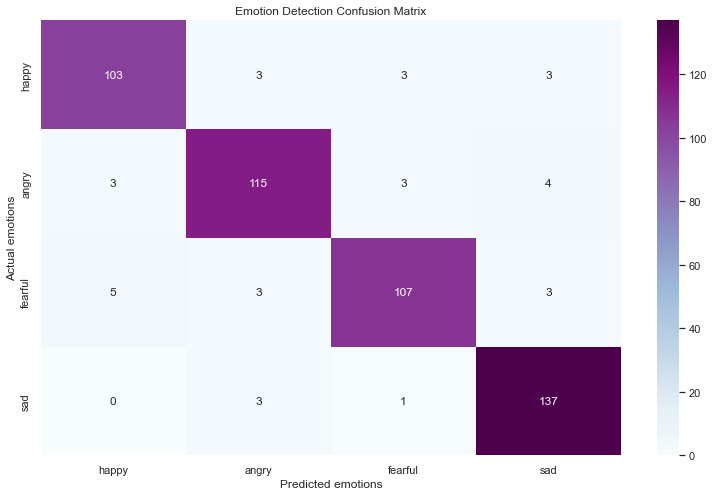

In [21]:
conf_matrix(y_test,y_pred,observed_emotions)

In [22]:
def split_into_intervals(data, k = 1600):
    intervals = [data[n*k:(n+1)*k] for n in range(int(len(data)/k))]
    return intervals



In [23]:
def extract_feature2(X, mfcc, chroma, mel,sample_rate):
    if chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [24]:
data, sr = librosa.load( "./test/4CH065I/1/kidvoice65I.wav" , sr=8000)  # write out the file name to test.

In [25]:
intervals = split_into_intervals(data,8000) #every 8000 means 1 seconds (24000 = 3seconds)

In [26]:
features = [extract_feature2(interval,True,True,True,8000) for interval in intervals] 

In [27]:
predictions = model.predict(features)

In [28]:
data, sr = librosa.load( "./test/4CH065I/1/kidvoice65I.wav" , sr=8000)  # write out the file name to test.
intervals = split_into_intervals(data,8000) #every 8000 means 1 seconds (24000 = 3seconds)
features = [extract_feature2(interval,True,True,True,8000) for interval in intervals] 
predictions = model.predict(features)

In [29]:
def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

import statistics
from statistics import mode


def most_common(List):
    return(mode(List))
def most_frequent(List):
    dict = {}
    count, itm = 0, ''
    for item in reversed(List):
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count :
            count, itm = dict[item], item
    return(itm)

from scipy import stats as s
def freq(a):
    print(int(s.mode(a)[0]))
import statistics
def find_max_mode(list1):
    list_table = statistics._counts(list1)
    len_table = len(list_table)

    if len_table == 1:
        max_mode = statistics.mode(list1)
    else:
        new_list = []
        for i in range(len_table):
            new_list.append(list_table[i][0])
        max_mode = max(new_list) # use the max value here
    return max_mode

In [30]:
def dominant_sequence(list1):
    total = 0
    buffer = list1[0]
    themax = 0
    themaxword = ""
    for i in range(len(list1)):
        if buffer == list1[i]:
            total = total +1
        else:
            if themax < total:
                themaxword = buffer
                themax = total
            total = 1
            buffer = list1[i]
    if themax < total:
        themaxword = buffer
    return themaxword,themax
        
a,b = dominant_sequence(predictions)
print(a,b)

fearful 5


In [31]:
import numpy as np
from matplotlib import pyplot as plt

def counter(list1):
    uniqued = ['angry', 'fearful', 'happy', 'sad']
    counter = 0
    counterlist = []
    for i in range(len(uniqued)):
        counter = 0
        for j in range(len(list1)):
            if list1[j] == uniqued[i]:
                counter = counter + 1
        counterlist.append(counter)
    return counterlist 
    fig = plt.figure(figsize =(3, 4))
    plt.pie(counterlist, labels = uniqued, autopct='%1.1f%%')
    plt.title(title)
    plt.show()
counter(predictions)

[11, 13, 19, 8]

In [32]:
def emotionalAnalsis(path):
    data, sr = librosa.load( path , sr=8000)  # write out the file name to test.
    intervals = split_into_intervals(data,8000) #every 8000 means 1 seconds (24000 = 3seconds)
    features = [extract_feature2(interval,True,True,True,8000) for interval in intervals] 
    predictions = model.predict(features)
    return counter(predictions)
emotionalAnalsis("./test/4CH065I/1/kidvoice65I.wav")

[11, 13, 19, 8]

In [33]:
paths = ["./test/4CH065I/1/kidvoice65I.wav", "./test/MAAP6/1/MAAP-C07-S06-20201006-MicrophoneIKid.wav"]
names = ['Turkish Subject: e434cda0', 'Macedonian Subject: e434aba0']
fig = plt.figure(figsize=(12,3), dpi=1600)
for i in range(2):
    name = names[i]
    d = emotionalAnalsis(paths[i])
    plt.subplot(1, 2, i+1)
    plt.pie(d, labels = ['angry', 'fear', 'happy', 'sad'], autopct='%1.1f%%')
    plt.title(names[i])

In [34]:
for file in glob.glob("child_voices/*.wav"):
    file_name=os.path.basename(file)
    data, sr = librosa.load( file , sr=8000)  # write out the file name to test.
    intervals = split_into_intervals(data,8000) #every 8000 means 1 seconds (24000 = 3seconds)
    features = [extract_feature2(interval,True,True,True,8000) for interval in intervals]
    print(file_name)
    predicted_values = model.predict(features)
    print(predicted_values)
    themaxword, themax = dominant_sequence(predicted_values)
    print("Most frequent emotion: ",find_max_mode(predicted_values)," Most Sequenced emotion",themaxword," : ",themax)
    print("-------------------------------------------")
    counter(predicted_values)

32
27
